In [9]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HancModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [11]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w_low,w_high,phi_low,phi_high]
 inputs_hh_z: []
 outputs_hh: [a,c]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma,phi_low,phi_high]
 unknowns: [K,L_low,L_high]
 targets: [clearing_A,clearing_L_low,clearing_L_high]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,L_low,L_high] -> [rK,w_low,w_high,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh]
 market_clearing: [A,A_hh,L_low,L_high,Y,C_hh,K] -> [L_hh_high,L_hh_low,I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


production_firm: [Gamma,K,L_low,L_high] -> [rK,w_low,w_high,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh]
market_clearing: [A,A_hh,L_low,L_high,Y,C_hh,K] -> [L_hh_high,L_hh_low,I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


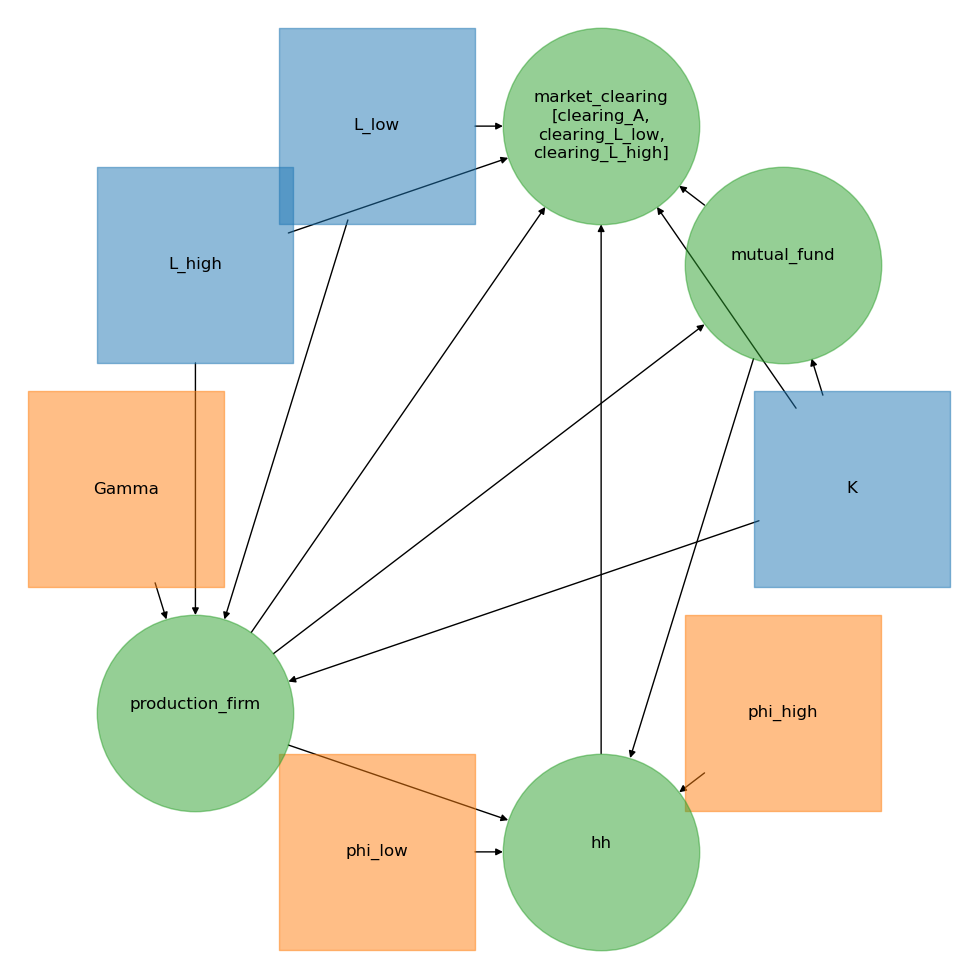

In [12]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

In [13]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [14]:
# Calibration parameters
ss.phi_high = 2.0
ss.phi_low = 1.0
# Some guesses for the steady state
ss.r = 0.05
ss.w_high = 1.5
ss.w_low = 1.0
ss.L_high = 1.0
ss.L_low = 0.5

In [15]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.2 secs [138 iterations]
household problem in ss simulated in 1.2 secs [86 iterations]


In [16]:
#model.find_ss(do_print=True)